In [1]:
running_colab = False

In [2]:
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    logs_directory = 'drive/MyDrive/summaries'
    !pip install -r "drive/MyDrive/requirements.txt"
else:
    logs_directory = 'summaries'

In [3]:
import time
import gym_2048
from tensorforce import Agent, Environment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
%load_ext tensorboard

In [14]:
import seaborn as sns

In [4]:
def train_agent(params, print_freq, file_name):
    ''' Function creating environment & agent based on params dict. 
    num_episodes defines how many episodes agent will train & print_freq defines 
    printing frequency. 
    Function will create dict of metrics & dict of params used in function & both
    will be saved as a csv with file_name'''

    # create a 2048 environment
    environment = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
        , max_episode_timesteps = params['max_episode_timesteps']
    )

    # create an agent
    agent = Agent.create(
        agent = 'dqn'
        , environment = environment
        , **params['agent_hyperparams']
        , summarizer = dict(directory=logs_directory
                            , summaries=[
                                "regularization-loss"
                                , "loss"
                                , "episode-length"
                                , "episode-reward"
                                , "objective-loss"
                                , "reward"
                                , "update-return"
                            ]
                           )
    )

    # instantiate lists to record global training metrics
    max_tiles = []
    scores = []
    updates = []
    valid_moves = []
    run_time = []
    start_training_time = time.time()

    for episode in range(params['num_episodes']):
        state = environment.reset()
        terminal = False

        #Checking metrics while training
        state_freeze = state.copy()
        num_updates = 0
        num_moves = 0
        invalid_moves = 0
        start_episode_time = time.time()

        while not terminal:
            #Core
            action = agent.act(states=dict(state=state,  action_mask=environment._environment.environment.get_invalid_moves()))
            state, terminal, reward = environment.execute(actions=action)
            log2_reward = reward if reward <= 0 else np.log2(reward)
            num_updates += agent.observe(terminal=terminal, reward=log2_reward)

            #Number of moves
            num_moves += 1

            #Number of invalid moves
            if (state == state_freeze).all():
                invalid_moves += 1
            state_freeze = state.copy()

        # Storing score and max tile
        max_tiles.append(environment._environment.environment.Matrix.max())
        scores.append(environment._environment.environment.score)
        updates.append(num_updates)
        valid_moves.append(num_moves)
        run_time.append(round(time.time() - start_episode_time,2))

        if episode % print_freq == 0:
            print('Episode {}: score = {}, terminal = {}, updates={}, max_tile={}, valid_moves={}, invalid_moves={}, seconds={}'\
                  .format(episode, environment._environment.environment.score , terminal, num_updates, max_tiles[-1], num_moves-invalid_moves, invalid_moves, round(time.time() - start_episode_time,2)))
        
    metrics_dict = {
        'max_tiles': max_tiles
        , 'scores': scores
        , 'updates': updates
        , 'valid_moves': valid_moves
        , 'run_time' : run_time
    }
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_path = f'training_runs/{file_name}_metrics.csv'
    metrics_df.to_csv(metrics_path)
    
    params_path = f'training_runs/{file_name}_params.json'
    with open(params_path, 'w') as fp:
        json.dump(params, fp)
    
    environment.close()
    
    return (metrics_df, params, agent)

In [5]:
agent_hyperparams_dict = {
    'max_episode_timesteps': 1000 # Maximum steps allowed in episode. This hyper-param is for environment
    , 'batch_size': 16
    , 'update_frequency': 4
    , 'learning_rate': 0.0001
    , 'discount': 0.8
    , 'memory': 30000
    , 'exploration': 0.05
    , 'target_sync_frequency': 4
    , 'horizon': 1
}

input_dict = {
    'max_episode_timesteps': 1000
    , 'num_episodes': 10_000
    , 'agent_hyperparams': agent_hyperparams_dict
}

In [6]:
test_df = train_agent(input_dict, 100, 'dqn_10k_0.8')

Episode 0: score = 3580.0, terminal = 1, updates=72, max_tile=256, valid_moves=295, invalid_moves=0, seconds=9.42
Episode 100: score = 1376.0, terminal = 1, updates=36, max_tile=128, valid_moves=145, invalid_moves=0, seconds=2.31
Episode 200: score = 1484.0, terminal = 1, updates=39, max_tile=128, valid_moves=157, invalid_moves=0, seconds=2.1
Episode 300: score = 3592.0, terminal = 1, updates=75, max_tile=256, valid_moves=301, invalid_moves=0, seconds=3.91
Episode 400: score = 1788.0, terminal = 1, updates=45, max_tile=128, valid_moves=182, invalid_moves=0, seconds=2.16
Episode 500: score = 1492.0, terminal = 1, updates=37, max_tile=128, valid_moves=148, invalid_moves=0, seconds=1.75
Episode 600: score = 2340.0, terminal = 1, updates=50, max_tile=256, valid_moves=200, invalid_moves=0, seconds=2.37
Episode 700: score = 3084.0, terminal = 1, updates=63, max_tile=256, valid_moves=255, invalid_moves=0, seconds=3.05
Episode 800: score = 4936.0, terminal = 1, updates=86, max_tile=512, valid_

Episode 7100: score = 5268.0, terminal = 1, updates=92, max_tile=512, valid_moves=369, invalid_moves=0, seconds=4.62
Episode 7200: score = 7156.0, terminal = 1, updates=122, max_tile=512, valid_moves=489, invalid_moves=0, seconds=6.15
Episode 7300: score = 2908.0, terminal = 1, updates=60, max_tile=256, valid_moves=240, invalid_moves=0, seconds=2.96
Episode 7400: score = 6548.0, terminal = 1, updates=111, max_tile=512, valid_moves=446, invalid_moves=0, seconds=5.51
Episode 7500: score = 3596.0, terminal = 1, updates=74, max_tile=256, valid_moves=298, invalid_moves=0, seconds=3.72
Episode 7600: score = 2632.0, terminal = 1, updates=55, max_tile=256, valid_moves=223, invalid_moves=0, seconds=2.84
Episode 7700: score = 1316.0, terminal = 1, updates=33, max_tile=128, valid_moves=135, invalid_moves=0, seconds=1.7
Episode 7800: score = 3372.0, terminal = 1, updates=69, max_tile=256, valid_moves=278, invalid_moves=0, seconds=3.51
Episode 7900: score = 7120.0, terminal = 1, updates=123, max_ti

In [8]:
test_df[2].save(directory='/Users/jean-bricetonin/code/Valentin_laurent/saved_model',filename='APG_0_8')

'/Users/jean-bricetonin/code/Valentin_laurent/saved_model/APG_0_8-1'

In [54]:
# Evaluate for 100 episodes
def test_agent(agent,n_episode):
    # create a 2048 environment
    environment = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
        , max_episode_timesteps = 1000
    )
    
    n_episode = n_episode
    dico_max_tiles_distribution = {}
    liste_score=[]
    dico_best_worst_episode = {'Worst':[],'Best':[], 'Episode # Worst':[], 'Episode # Best':[]}

    for episode in range(n_episode):
        sum_rewards = 0.0
        states = environment.reset()
        list_states=[]
        internals = agent.initial_internals()
        terminal = False

        while not terminal:
            actions, internals = agent.act(
                states=dict(state=states,  action_mask=environment._environment.environment.get_invalid_moves()), internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            matrix = environment._environment.environment.Matrix
            list_states.append(matrix.copy())
            sum_rewards += reward

        liste_score.append(sum_rewards)

        if sum_rewards >= max(liste_score):
            dico_best_worst_episode['Best'] = list_states
            dico_best_worst_episode['Episode # Best'] = episode
        elif sum_rewards <= min(liste_score):
            dico_best_worst_episode['Worst'] = list_states
            dico_best_worst_episode['Episode # Worst'] = episode

        dico_max_tiles_distribution.setdefault(environment._environment.environment.Matrix.max(),0)
        dico_max_tiles_distribution[environment._environment.environment.Matrix.max()] += 1

    return dico_best_worst_episode, liste_score, dico_max_tiles_distribution


In [10]:
def sort_dico(dico):
    dico_sorted={}
    for k,v in dict(sorted(dico.items())).items():
        k_str = str(k)
        dico_sorted[k_str] = v

    return dico_sorted

def plot_metrics(dico_sorted,rewards):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Max tile distribution')
    plt.bar(*zip(*dico_sorted.items()))

    plt.subplot(1, 2, 2)
    plt.title('Score distribution')
    sns.histplot(rewards, kde=True)

    print(f'Mean score over the test: {np.mean(rewards)}')
    print(f'Median score over the test: {np.median(rewards)}')
    print(f'Std score over the test: {np.std(rewards)}')
    print(f'Max tile over the test: {max([int(bins) for bins in dico_sorted.keys()])}')

In [55]:
best_of, liste_score, max_t_distrib = test_agent(test_df[2],5)

In [72]:
best_of['Best']

[array([[0, 0, 0, 0],
        [0, 2, 0, 0],
        [0, 0, 0, 0],
        [2, 2, 0, 0]]),
 array([[0, 2, 0, 0],
        [2, 0, 0, 0],
        [0, 0, 0, 0],
        [4, 0, 0, 0]]),
 array([[2, 2, 0, 2],
        [4, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]),
 array([[4, 2, 0, 0],
        [4, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 2, 0, 0]]),
 array([[8, 4, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 0, 0]]),
 array([[2, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [8, 4, 0, 2]]),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [2, 0, 2, 0],
        [8, 4, 0, 2]]),
 array([[2, 0, 0, 0],
        [0, 0, 0, 0],
        [4, 0, 0, 0],
        [8, 4, 2, 0]]),
 array([[2, 4, 2, 0],
        [4, 0, 0, 0],
        [8, 2, 0, 0],
        [0, 0, 0, 0]]),
 array([[2, 0, 0, 0],
        [2, 0, 0, 0],
        [4, 4, 0, 0],
        [8, 2, 2, 0]]),
 array([[2, 0, 0, 0],
        [2, 0, 0, 0],
        [8, 0, 0, 0],
        [8, 4, 0, 2]]),
 array([[ 

In [33]:
import time

In [61]:
def pretty_print(layout):
    from math import log2
    def parse_color(cell_value):
        if cell_value>0:
            colors = ["#EEE4DA", "#ECE0CA", "#F2B179", "#F59565", "#F57C5F", "#F65D3B", "#EDCE71", "#EDCC63", "#EDC850", "#EDC53F", "#EEC22E", "#3E3933"]
            return colors[int(log2(cell_value))-1]
        else:
            return "#CDC0B4"

    def cell_block(cell_value):
        return '''
        <td style=font-size:{}px;background-color:#BBADA0;text-align:center;width:100%>
            <div style=color:#776E65;background-color:{};width:60px;height:60px;text-align:center><strong>{}</strong>
            </div>
        </td>'''.format('14', parse_color(cell_value), cell_value if cell_value>0 else '')
    return '''
            <div style=background-color:#BBADA0;width:300px;height:300px>
            <table style=width:100%;height:100%>
              <tr>
                {}
                </tr>
              <tr>
              {}
              </tr>
              <tr>
              {}
              </tr>
              <tr>
              {}
              </tr>
            </table>
            </div>
            '''.format('\n'.join([cell_block(val) for val in layout[0,:]]),
                      '\n'.join([cell_block(val) for val in layout[1,:]]),
                       '\n'.join([cell_block(val) for val in layout[2,:]]),
                       '\n'.join([cell_block(val) for val in layout[3,:]]))


In [123]:
from IPython.display import clear_output

In [131]:
for k in best_of['Best']:
    clear_output(wait=True)
    display(HTML(pretty_print(k)))
    time.sleep(0.5)


,2,8,4
,8,32,16
,,,
2,,,2


KeyboardInterrupt: 

In [91]:
len(best_of['Best'])

380

In [118]:
HTML(pretty_print(best_of['Best'][1]))

,2,,
2,,,
,,,
4,,,


In [120]:
for state in best_of['Best']:
    HTML(pretty_print(state))

In [80]:
result = input("coucou")
print(result)

coucouhvilvd
hvilvd


Mean score over the test: 3859.756
Median score over the test: 3256.0
Std score over the test: 1759.4825297410598
Max tile over the test: 1024


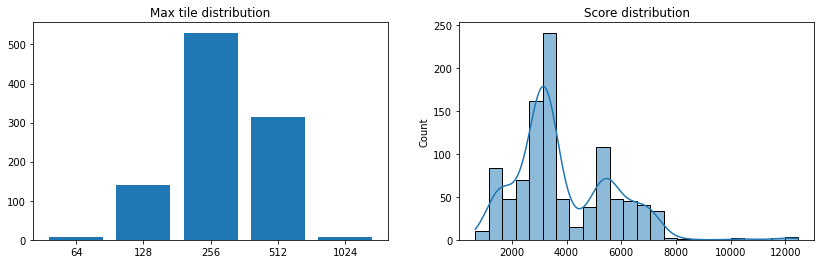

In [15]:
plot_metrics(sort_dico(max_t_distrib),liste_score)